In [1]:
#linear regression and support vector machine


In [2]:
#linear regression and bacth stochastic gradient descent

In [3]:
#1) load the training set and validation set

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from io import BytesIO


#training_set = load_svmlight_file('C:\\Users\\dell\\Desktop\\a9a.t')
#validation_set =load_svmlight_file('C:\\Users\\dell\\Desktop\\a9a.t')
    
x,y = load_svmlight_file('C:\\Users\\dell\\Desktop\\a9a.t')
x_train, x_val, y_train, y_val=train_test_split(x,y, test_size=0.4, random_state=0)
x_train = x_train.toarray()
x_val = x_val.toarray()


In [122]:
import numpy as np
from collections import defaultdict

n_samples_training, n_features_training = x_train.shape
x_train = np.concatenate((x_train, np.ones(shape=(n_samples_training, 1))), axis=1)
y_train = y_train.reshape((n_samples_training, 1))

n_samples_val, n_features_val = x_val.shape
x_val = np.concatenate((x_val, np.ones(shape=(n_samples_val, 1))), axis=1)
y_val = y_val.reshape((n_samples_val, 1))


In [123]:
#2) initialize logistic regression parameter
class Model(object):
    def __init__(self, n_features):
        self.params = np.random.random(size=(n_features, 1))
        self.diffs = np.zeros((n_features, 1))
        self.recorder = defaultdict(list)

    def train(self, X, Y):
        pass

    def validate(self, X, Y):
        self.__loss__(X, Y, "validation")

    def predict(self, X):
        pass

    def __calculate_gradient__(self, params=None):
        pass

    def __loss__(self, X, Y, key):
        pass

In [124]:
class SVM(Model):
    def __init__(self, n_features, C):
        super(SVM, self).__init__(n_features=n_features)
        self.C = C
        self.x_train = None
        self.y_train = None

    def train(self, X, Y):
        self.x_train = X
        self.y_train = Y

    def predict(self, X):
        return np.where(np.dot(X, self.params) > 0, 1, -1)

    def __calculate_gradient__(self, params=None):
        if params is None:
            params = self.params
        h = 1 - self.y_train * np.dot(self.x_train, params)
        y_mask = np.where(h > 0, self.y_train, 0)
        self.diffs = params - self.C * np.dot(self.x_train.transpose(), y_mask)

    def __loss__(self, X, Y, key):
        loss = np.sum(self.params * self.params) \
               + self.C * np.sum(np.maximum(1 - Y * np.dot(X, self.params), 0))
        self.recorder[key].append(loss)

In [125]:
class Optimizer(object):
    def __init__(self, model):
        self.model = model
        self.color = None

    def step(self):
        pass

In [126]:
class SGD(Optimizer):
    def __init__(self, model, learning_rate, momentum=None):
        super(SGD, self).__init__(model=model)
        self.color = "r"
        self.learning_rate = learning_rate
        self.momentum = momentum
        if momentum is not None:
            self.v = np.zeros_like(self.model.diffs)

    def step(self):
        self.model.__calculate_gradient__()
        if self.momentum is None:
            self.model.params -= self.learning_rate * self.model.diffs
        else:
            self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
            self.model.params -= self.v

In [127]:
class NAG(Optimizer):
    def __init__(self, model, learning_rate, momentum):
        super(NAG, self).__init__(model=model)
        self.color = "y"
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.v = np.zeros_like(self.model.diffs)

    def step(self):
        self.model.__calculate_gradient__(params=self.model.params - self.momentum * self.v)
        self.v = self.momentum * self.v + self.learning_rate * self.model.diffs
        self.model.params -= self.v

In [128]:
class RMSProP(Optimizer):
    def __init__(self, model, leaning_rate, weight_decay):
        self.color = "c"
        super(RMSProP, self).__init__(model=model)
        self.G = np.zeros_like(self.model.diffs)
        self.learning_rate = leaning_rate
        self.weight_decay = weight_decay
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.weight_decay * self.G + (1 - self.weight_decay) * self.model.diffs * self.model.diffs
        self.model.params -= self.learning_rate / np.sqrt(self.G + self.epsilon) * self.model.diffs


In [129]:
class AdaDelta(Optimizer):
    def __init__(self, model, gamma):
        super(AdaDelta, self).__init__(model=model)
        self.color = "b"
        self.gamma = gamma
        self.G = np.zeros_like(self.model.diffs)
        self.delta = np.zeros_like(self.model.diffs)
        self.delta_theta = np.zeros_like(self.model.diffs)
        self.epsilon = 1e-4

    def step(self):
        self.model.__calculate_gradient__()
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        self.delta_theta = -(np.sqrt(self.delta + self.epsilon)
                             / np.sqrt(self.G + self.epsilon)) * self.model.diffs
        self.model.params += self.delta_theta
        self.delta = self.gamma * self.delta + (1 - self.gamma) * self.delta_theta * self.delta_theta


In [130]:
class Adam(Optimizer):
    def __init__(self, model, beta, gamma, eta):
        super(Adam, self).__init__(model=model)
        self.color = "m"
        self.beta = beta
        self.gamma = gamma
        self.eta = eta
        self.m = np.zeros_like(self.model.diffs)
        self.G = np.zeros_like(self.model.diffs)
        self.epsilon = 1e-8

    def step(self):
        self.model.__calculate_gradient__()
        self.m = self.beta * self.m + (1 - self.beta) * self.model.diffs
        self.G = self.gamma * self.G + (1 - self.gamma) * self.model.diffs * self.model.diffs
        alpha = self.eta * (np.sqrt(1 - self.gamma)) / (1 - self.beta)
        self.model.params -= alpha * self.m / np.sqrt(self.G + self.epsilon)

In [131]:
optimizers = [
    SGD(model=SVM(n_features=123 + 1, C=1), learning_rate=0.00001, momentum=0.5),
    NAG(model=SVM(n_features=123 + 1, C=1), learning_rate=0.0001, momentum=0.9),
    RMSProP(model=SVM(n_features=123 + 1,C=1),leaning_rate=0.1,weight_decay=0.9),
    AdaDelta(model=SVM(n_features=123 + 1,C=1), gamma=0.95),
    Adam(model=SVM(n_features=123 + 1,C=1),beta=0.9,gamma=0.999,eta=0.1)
]

In [141]:
max_epoch = 100
batch_size = 10000
for epoch in range(max_epoch):
    indexes = np.random.randint(0, n_samples_training, size=batch_size)
    for optimizer in optimizers:
        optimizer.model.train(x_train[indexes], y_train[indexes])
        optimizer.step()
        optimizer.model.validate(x_val, y_val)

from sklearn.metrics import classification_report
print("\t\t\t"+optimizers[0].model.__class__.__name__)
print("-"*60)
for optimizer in optimizers:
    print("\t\t\t"+optimizer.__class__.__name__)
    print("-"*60)
    print(classification_report(y_val,
                                optimizer.model.predict(x_val),
                                target_names=["positive", "negative"],
                                digits=3))

ValueError: shapes (10000,123) and (124,1) not aligned: 123 (dim 1) != 124 (dim 0)

NameError: name 'optimizers' is not defined

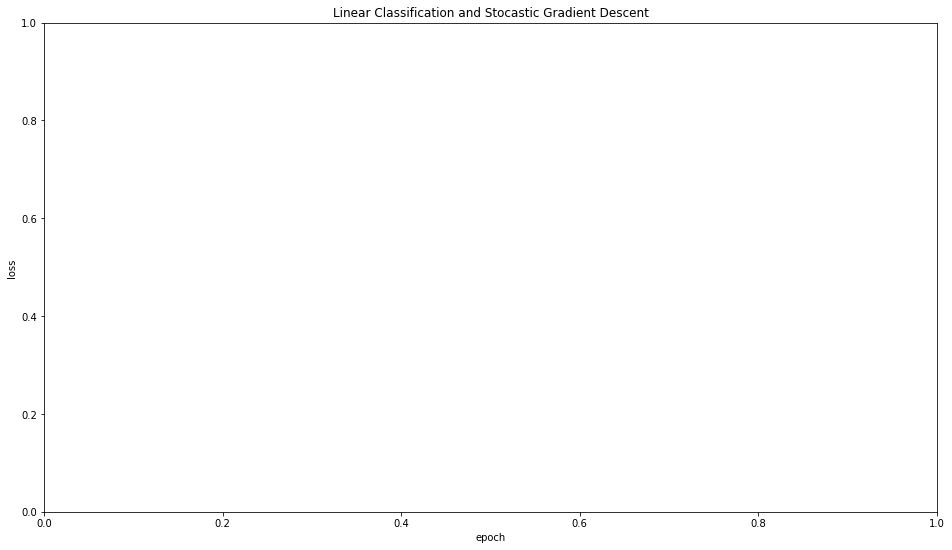

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,9))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Linear Classification and Stocastic Gradient Descent")
for optimizer in optimizers:
    plt.plot(optimizer.model.recorder["validation"], color=optimizer.color, label=optimizer.__class__.__name__)
plt.legend()
plt.show()

In [138]:
x_val.shape


(6513, 123)

In [139]:

y_val.shape

(6513, 1)